In [1]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib as mpl
import pandas as pd
import numpy as np
import pickle as pkl

In [2]:
def stationarity_check(time_series=pd.Series, rolling_window:int=48, center:bool=False, file_name:str=''):
    """
        This function check the stationarity in the given time series data
        input: 
            time_series: pandas Time series
            rolling_window: intiger to calculate the rolling period
            center: boolion, default False. how to do rolling window
            file_name: string, defauly Null, if value given, it will store the grpah into a file
        output: 
            Results of Dickey-Fuller Test as Pandas Dataframe
            plot of stationary check
    """
    # Calculate rolling statistics
    roll_mean = time_series.rolling(window=rolling_window, center=center).mean()
    roll_std = time_series.rolling(window=rolling_window, center=center).std()

    # Perform the Dickey Fuller test
    test_df = adfuller(time_series) 
    output_df = pd.Series(test_df[0:4], index=['Test Statistic', 
                                           'p-value', 
                                           '#Lags Used', 
                                           'Number of Observations Used'])
    for key, value in test_df[4].items():
        output_df['Critical Value (%s)'%key] = value
    # Plot rolling statistics:
    fig  = plt.figure(figsize=(12,6))
    orig = plt.plot(time_series, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std  = plt.plot(roll_std, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    # plt.show(block=False)
    if file_name != '':
        plt.savefig(file_name)
    return output_df

In [3]:
def decomposition_plot(time_series:pd.Series, period:int=48, file_name:str=''):
    """
        This function plot the decomposition in the given time series data
        input: 
            time_series: pandas Time series
            period: intiger to calculate the decomposition
            file_name: string, defauly Null, if value given, it will store the grpah into a file
        output: 
            plot
    """
    # Apply seasonal_decompose 
    decomposition = seasonal_decompose(time_series, period = period)
    
    # Get trend, seasonality, and residuals
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plotting
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(time_series, label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()
    if file_name != '':
        plt.savefig(file_name)

In [4]:
def plot_acf_pacf(time_series:pd.Series, lags:int=48, file_name:str=''):
    """
        This function plot the acf and pacf in the given time series data
        input: 
            time_series: pandas Time series
            lags: intiger to calculate the acf and pacf
            file_name: string, defauly Null, if value given, it will store the grpah into a file
        output: 
            plot
    """    
    fig,ax = plt.subplots(nrows=3, figsize=(10,8))
    time_series.plot(ax=ax[0])
    # Plot acf, pavf
    plot_acf(time_series, ax=ax[1], lags=lags)
    plot_pacf(time_series, ax=ax[2], lags=lags) 
    fig.tight_layout()
    for a in ax[1:]:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=lags, integer=True))
        a.xaxis.grid()
    if file_name != '':
        plt.savefig(file_name)    

In [5]:
# Plotting Predictions
def plot_train_test_pred(train:pd.Series, test:pd.Series, pred_df:pd.DataFrame, file_name:str=''):
    """
        This function plot the training, test and predictied dataset in a graph
        input: 
            train: pandas Time series
            test: pandas Time series
            pred_df: pandas DataFrame
            file_name: string, defauly Null, if value given, it will store the grpah into a file
        output: 
            plot
    """      
    fig,ax = plt.subplots(figsize=(12,7))
    kws = dict(marker='o')
    ax.plot(train,label='Train',**kws)
    ax.plot(test,label='Test',**kws)
    ax.plot(pred_df['pred'],label='Prediction',ls='--',linewidth=3)
    ax.fill_between(x=pred_df.index,y1=pred_df['lower'],y2=pred_df['upper'],alpha=0.3)
    ax.set_title('Model Validation', fontsize=22)
    ax.legend(loc='upper left')
    fig.tight_layout()
    if file_name != '':
        plt.savefig(file_name)

In [6]:
def forecast(model, steps:int=48):
    """
        This function check the forecast from the given ARIMA model for the number of steps provided
        input: 
            model: trained Auto Arima model
            Steps: intiger number of steps(timestamps) to be predicted
        output: 
            Results predicted result as Pandas Dataframe
    """
    forecast, conf_int = model.predict(steps, return_conf_int=True)
    pred_df = forecast.to_frame()
    pred_df.rename(columns={0:'pred'},inplace=True)
    pred_df['lower'] = conf_int[:, 0]
    pred_df['upper'] = conf_int[:, 1]
    pred_df = pred_df[['lower', 'upper', 'pred']]
    return pred_df

In [7]:
FORECAST_PERIOD = 48

In [8]:
# Train Test Split Index
data_df = pd.read_csv("../Data/pre_processed_final_data.csv")
data_df['date_time'] = pd.to_datetime(data_df['date_time'], infer_datetime_format=True, dayfirst=False)
data_df.set_index('date_time', inplace=True)

In [9]:
ts = data_df['System Sell Price(GBP/MWh)']
ts.describe()

count    79968.000000
mean        98.229089
std        119.055803
min       -185.330000
25%         35.000000
50%         61.850000
75%        130.000000
max       4037.800000
Name: System Sell Price(GBP/MWh), dtype: float64

Test Statistic                -1.067667e+01
p-value                        4.037234e-19
#Lags Used                     6.400000e+01
Number of Observations Used    7.990300e+04
Critical Value (1%)           -3.430432e+00
Critical Value (5%)           -2.861576e+00
Critical Value (10%)          -2.566789e+00
dtype: float64


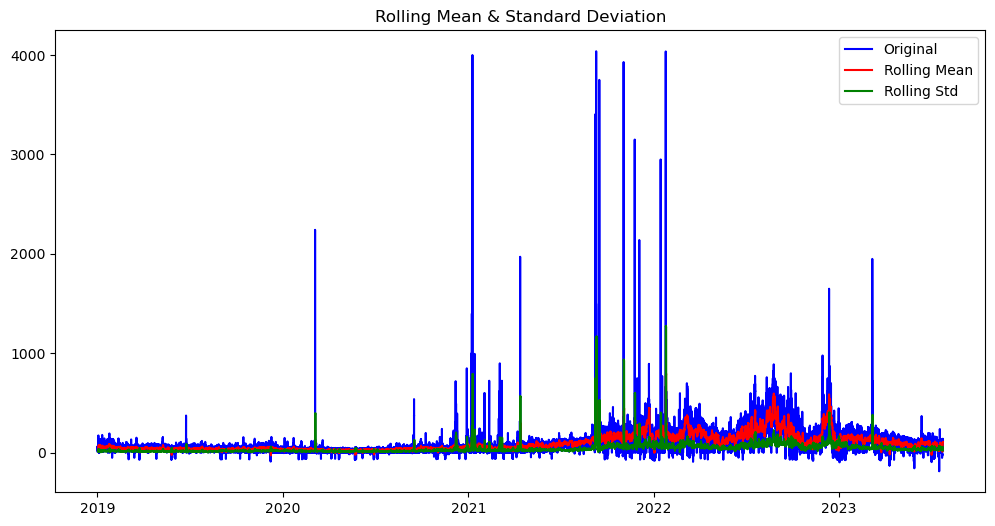

In [10]:
stationarity_df = stationarity_check(time_series=ts, 
                                     rolling_window=FORECAST_PERIOD, 
                                     center=False, 
                                     file_name='../Output/stationarity_check.png')
print(stationarity_df)

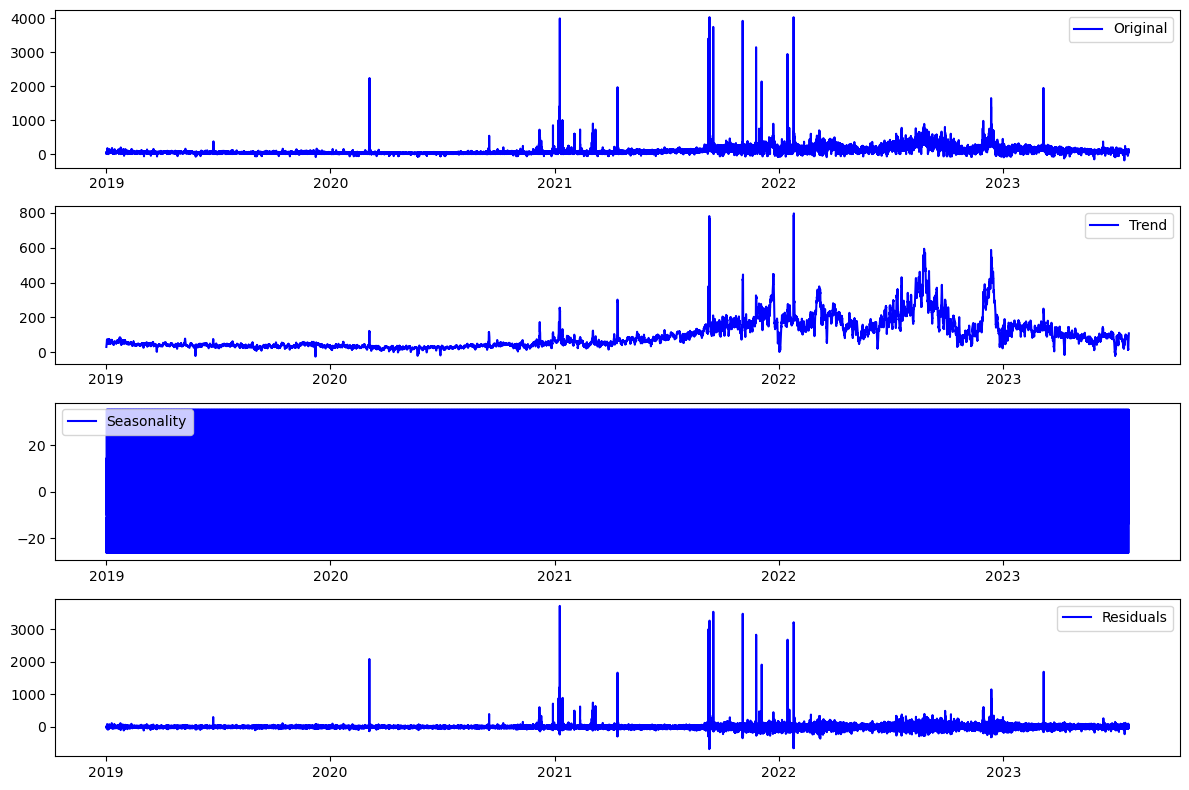

In [11]:
decomposition_plot(ts, period=FORECAST_PERIOD,  file_name="../Output/decomposition_plot.png")

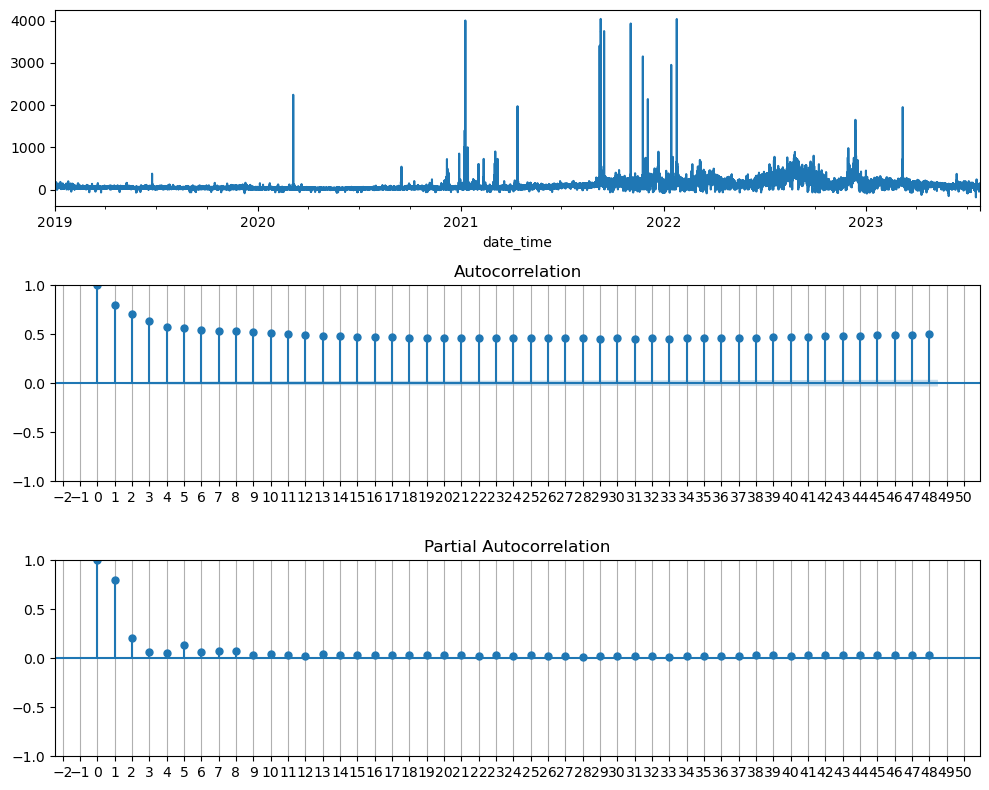

In [12]:
plot_acf_pacf(ts, lags=FORECAST_PERIOD, file_name="../Output/acf_pacf.png")

In [13]:
# Split the training and test period 
train = ts[:'2022-12-31']
test = ts['2023-01-01':]

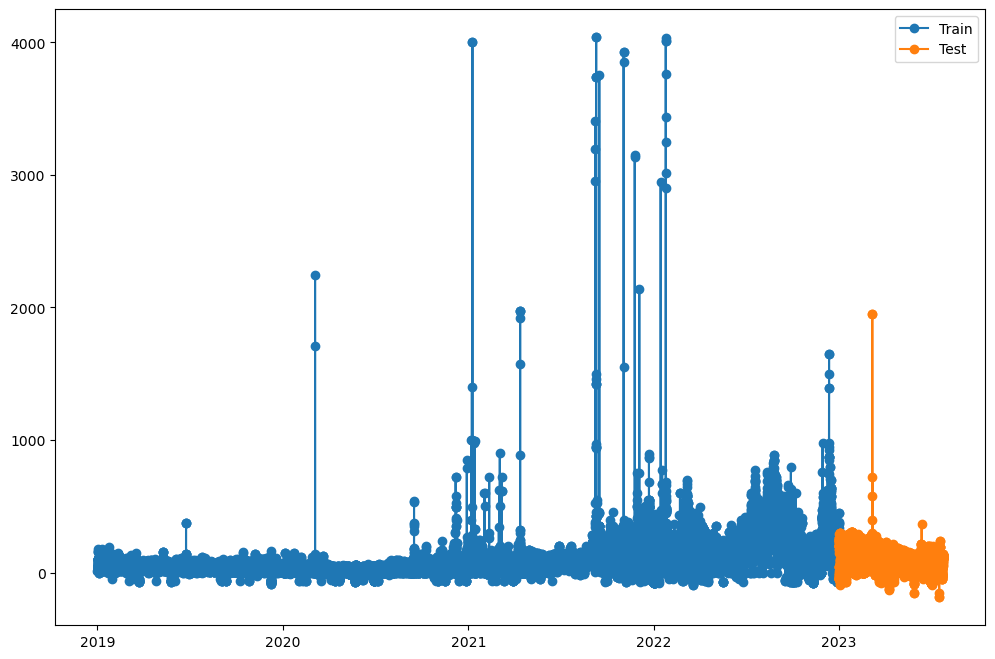

In [14]:
# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(train, label='Train', **kws)
plt.plot(test, label='Test', **kws)
ax.legend(bbox_to_anchor=[1,1]);
plt.savefig("../Output/train_test_split.png")

In [15]:
model = auto_arima(train, start_p=0, start_q=0)

In [16]:
# Returns a dataframe
pred_df = forecast(model, steps = len(test))

In [17]:
# Calculate MSE 
mse = mean_squared_error(pred_df['pred'], test) 
# Calculate R Square
r2 = r2_score(pred_df['pred'], test)
print("MSE", mse)
print("R2", r2)

MSE 4830.334480617671
R2 -10515.828792885506


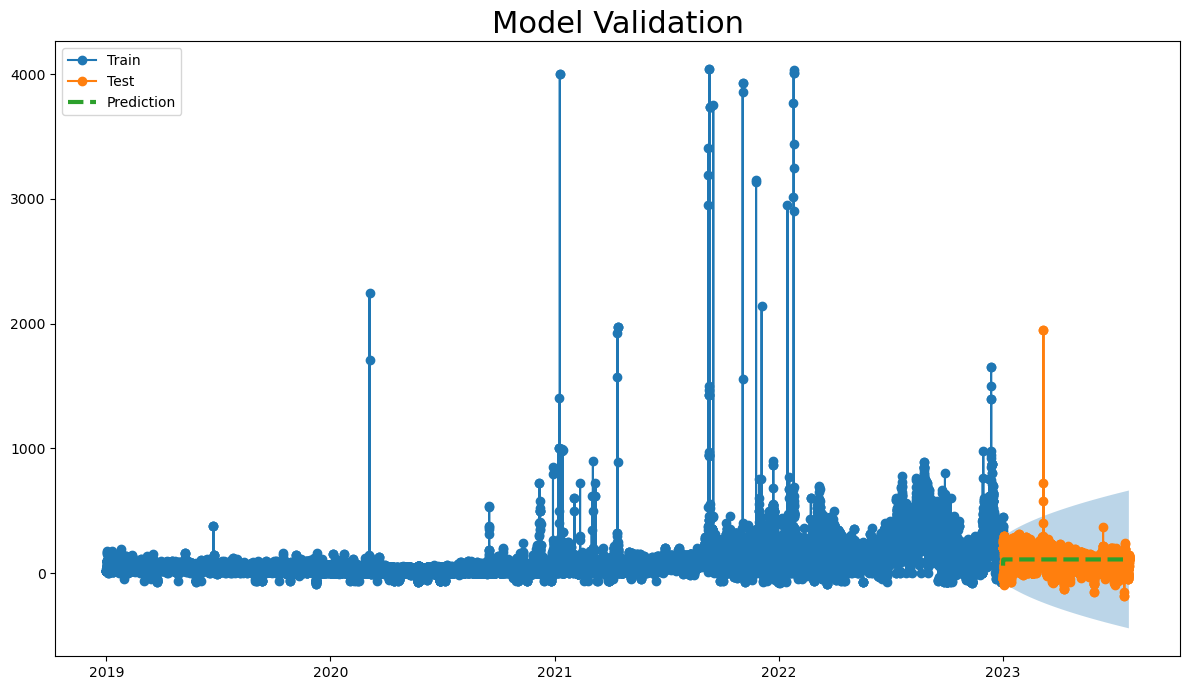

In [18]:
plot_train_test_pred(train, test, pred_df, file_name="../Output/arima_train_test_pred.png")

In [19]:
summary = model.summary()

In [20]:
with open("../Output/Arima_model_summary.pkl", mode='wb') as file:
    pkl.dump(summary, file)
    file.close()

In [21]:
with open("../Models/Arima_model.pkl", mode='wb') as file:
    pkl.dump(model, file)
    file.close()

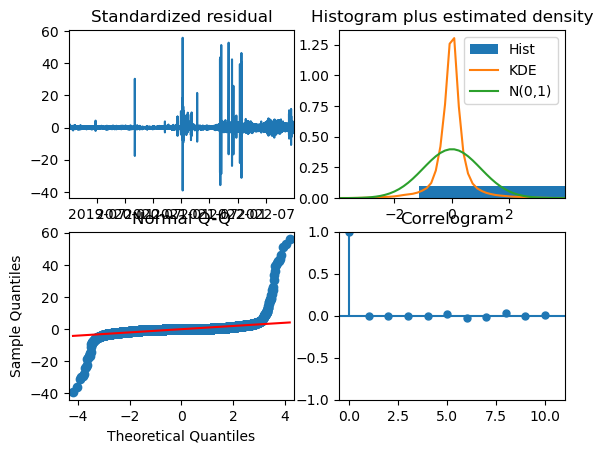

In [22]:
fig = model.plot_diagnostics()
fig.savefig("../Output/Arima_dignostics.png")